<a href="https://colab.research.google.com/github/galievaz/bike-sharing-project/blob/main/project-notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle

In [6]:
!mkdir -p /root/.kaggle
!touch /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

In [12]:
!ls

sample_data


In [10]:
!cd ..

In [22]:
import os

os.environ['KAGGLE_USERNAME'] = kaggle_username
os.environ['KAGGLE_KEY'] = kaggle_key

!pip install kaggle

In [19]:
import json
kaggle_username = "dulic11221"
kaggle_key = "0a2244ded4f31a255a918ba1a934143b"

# Save API token the kaggle.json file
with open("/root/.kaggle/kaggle.json", "w") as f:
    f.write(json.dumps({"username": kaggle_username, "key": kaggle_key}))

In [20]:
!ls -l /root/.kaggle/

total 4
-rw------- 1 root root 69 Apr 19 08:31 kaggle.json


In [23]:
!kaggle competitions download -c bike-sharing-demand
# If you already downloaded it you can use the -o command to overwrite the file
!unzip -o bike-sharing-demand.zip

  0% 0.00/189k [00:00<?, ?B/s]
100% 189k/189k [00:00<00:00, 70.6MB/s]
Archive:  bike-sharing-demand.zip
  inflating: sampleSubmission.csv    
  inflating: test.csv                
  inflating: train.csv               


In [24]:
!pip install -U pip
!pip install -U setuptools wheel
!pip install -U "mxnet<2.0.0" bokeh==2.0.1
!pip install autogluon --no-cache-dir

     |████████████████████████████████| 2.1 MB 5.1 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.4 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 57.4.0
    Uninstalling setuptools-57.4.0:
      Successfully uninstalled setuptools-57.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.3/47.3 MB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 82.4 MB/s eta 0:00:00
  Preparing metadata (setup.py

In [25]:
import pandas as pd
from autogluon.tabular import TabularPredictor

In [28]:
# Create the train dataset in pandas by reading the csv
# Set the parsing of the datetime column so you can use some of the `dt` features in pandas later
train = pd.read_csv('./train.csv')
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [29]:
features=['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed']
target=['count']
train=train[list(features+target)]

In [30]:
train['datetime'] = pd.to_datetime(train['datetime'], format='%Y-%m-%d %H:%M:%S')

In [31]:
train.dtypes

datetime      datetime64[ns]
season                 int64
holiday                int64
workingday             int64
weather                int64
temp                 float64
atemp                float64
humidity               int64
windspeed            float64
count                  int64
dtype: object

In [32]:
# Simple output of the train dataset to view some of the min/max/varition of the dataset features.
train.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,977.000000


In [33]:
# Create the test pandas dataframe in pandas by reading the csv, remember to parse the datetime!
test = pd.read_csv('./test.csv')
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [34]:
test['datetime'] = pd.to_datetime(test['datetime'], format='%Y-%m-%d %H:%M:%S')

In [35]:
# Same thing as train and test dataset
submission = pd.read_csv('./sampleSubmission.csv')
submission.head()

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


In [36]:
submission['datetime'] = pd.to_datetime(submission['datetime'], format='%Y-%m-%d %H:%M:%S')

# Step 3: Train a model using AutoGluon’s Tabular **Prediction**

In [37]:
predictor = TabularPredictor(label="count").fit(
    train_data=train,
    time_limit=600,
    presets="best_quality"
)

No path specified. Models will be saved in: "AutogluonModels/ag-20220419_084331/"
Presets specified: ['best_quality']
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20220419_084331/"
AutoGluon Version:  0.4.0
Python Version:     3.7.13
Operating System:   Linux
Train Data Rows:    10886
Train Data Columns: 9
Label Column: count
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == int and many unique label-values observed).
	Label info (max, min, mean, stddev): (977, 1, 191.57413, 181.14445)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    12263.81 MB
	Train Data (Original)  Memory Usage: 0.

# **Review AutoGluon's training run with ranking of models that did the best.**

In [38]:
predictor = TabularPredictor.load('AutogluonModels/ag-20220419_084331')
predictor.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3  -53.061127      18.644824  551.424813                0.000987           0.541018            3       True         14
1   RandomForestMSE_BAG_L2  -53.376073      14.692400  419.337447                0.630835          32.634096            2       True         12
2          LightGBM_BAG_L2  -55.063841      14.372138  412.677914                0.310573          25.974563            2       True         11
3          CatBoost_BAG_L2  -55.744678      14.143787  437.349613                0.082222          50.646262            2       True         13
4        LightGBMXT_BAG_L2  -60.267904      17.620208  441.628874                3.558643          54.925523            2       True         10
5    KNeighborsDist_BAG_L1  -84.125061       0.106330    0.070269         

{'leaderboard':                      model   score_val  pred_time_val    fit_time  \
 0      WeightedEnsemble_L3  -53.061127      18.644824  551.424813   
 1   RandomForestMSE_BAG_L2  -53.376073      14.692400  419.337447   
 2          LightGBM_BAG_L2  -55.063841      14.372138  412.677914   
 3          CatBoost_BAG_L2  -55.744678      14.143787  437.349613   
 4        LightGBMXT_BAG_L2  -60.267904      17.620208  441.628874   
 5    KNeighborsDist_BAG_L1  -84.125061       0.106330    0.070269   
 6      WeightedEnsemble_L2  -84.125061       0.107578    1.132542   
 7    KNeighborsUnif_BAG_L1 -101.546199       0.121799    0.059016   
 8   RandomForestMSE_BAG_L1 -116.621736       0.543419   14.736302   
 9     ExtraTreesMSE_BAG_L1 -124.637158       0.543231    4.976221   
 10         CatBoost_BAG_L1 -130.721070       0.126477  203.071945   
 11         LightGBM_BAG_L1 -131.054162       2.005934   35.171104   
 12       LightGBMXT_BAG_L1 -131.460909       9.939164   67.023231   
 13  

In [39]:
predictor.feature_importance(train)

Computing feature importance via permutation shuffling for 9 features using 1000 rows with 3 shuffle sets...
	294.94s	= Expected runtime (98.31s per shuffle set)
	178.33s	= Actual runtime (Completed 3 of 3 shuffle sets)


,importance,stddev,p_value,n,p99_high,p99_low
datetime,189.127258,1.030041,0.000005,3,195.029505,183.225012
holiday,0.055575,0.073456,0.160162,3,0.476489,-0.365339
season,-0.480436,0.112987,0.991029,3,0.166992,-1.127863
weather,-0.821395,0.173759,0.992705,3,0.174264,-1.817054
workingday,-2.009698,0.546990,0.988093,3,1.124617,-5.144013
windspeed,-2.215686,0.583512,0.988827,3,1.127902,-5.559274
temp,-2.396432,0.102817,0.999693,3,-1.807280,-2.985585
humidity,-2.499229,0.621630,0.989997,3,1.062781,-6.061239
atemp,-2.533905,0.033120,0.999972,3,-2.344126,-2.723684


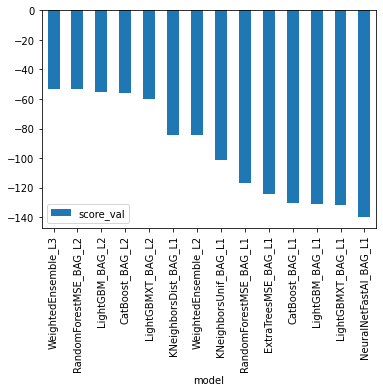

In [40]:
predictor.leaderboard(silent=True).plot(kind="bar", x="model", y="score_val")

# Create predictions from test dataset

In [41]:
predictions = predictor.predict(test)
predictions.head()

0    24.060295
1    42.784004
2    46.799011
3    49.674816
4    52.136616
Name: count, dtype: float32

In [42]:
#NOTE: Kaggle will reject the submission if we don't set everything to be > 0.
# How many negative values do we have?
any(predictions<0)

False

# Set predictions to submission dataframe, save, and submit

In [43]:
submission["count"] = predictions
submission.to_csv("submission.csv", index=False)

In [44]:
!kaggle competitions submit -c bike-sharing-demand -f submission.csv -m "first raw submission"

100% 188k/188k [00:01<00:00, 164kB/s]
Successfully submitted to Bike Sharing Demand

View submission via the command line or in the web browser under the competition's page - My Submissions

In [45]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                                          date                 description           status    publicScore  privateScore  
------------------------------------------------  -------------------  --------------------  --------  -----------  ------------  
submission.csv                                    2022-04-19 09:04:03  first raw submission  complete  1.79572      1.79572       
submission_new_features_distil_more features.csv  2022-04-12 12:13:19                        complete  0.52906      0.52906       
submission_new_features_distil.csv                2022-04-11 15:05:45                        complete  0.57097      0.57097       
submission_new_features.csv                       2022-04-11 12:24:17                        complete  0.57786      0.57786       


Initial score of 1.79572

# **Step 4: Exploratory Data Analysis and Creating an additional feature**

Any additional feature will do, but a great suggestion would be to separate out the datetime into hour, day, or month parts.


In [46]:
# create a new feature
train['year'] = train['datetime'].dt.year
train['month'] = train['datetime'].dt.month
train['day'] = train['datetime'].dt.day
train['hour'] = train['datetime'].dt.hour

test['year'] = test['datetime'].dt.year
test['month'] = test['datetime'].dt.month
test['day'] = test['datetime'].dt.day
test['hour'] = test['datetime'].dt.hour

train

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,16,2011,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,40,2011,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,32,2011,1,1,2
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,13,2011,1,1,3
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,1,2011,1,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,336,2012,12,19,19
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,241,2012,12,19,20
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,168,2012,12,19,21
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,129,2012,12,19,22


In [47]:
test

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,day,hour
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027,2011,1,20,0
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000,2011,1,20,1
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000,2011,1,20,2
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014,2011,1,20,3
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014,2011,1,20,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6488,2012-12-31 19:00:00,1,0,1,2,10.66,12.880,60,11.0014,2012,12,31,19
6489,2012-12-31 20:00:00,1,0,1,2,10.66,12.880,60,11.0014,2012,12,31,20
6490,2012-12-31 21:00:00,1,0,1,1,10.66,12.880,60,11.0014,2012,12,31,21
6491,2012-12-31 22:00:00,1,0,1,1,10.66,13.635,56,8.9981,2012,12,31,22


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff51d77f0d0>,
      dtype=object)

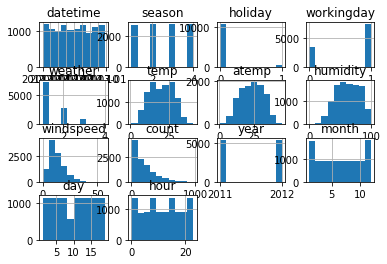

In [48]:
# Create a histogram of all features to show the distribution of each one relative to the data. This is part of the exploritory data analysis
train.hist()

In [49]:
train.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,month,day,hour
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,191.574132,2011.501929,6.521495,9.992559,11.541613
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,181.144454,0.500019,3.444373,5.476608,6.915838
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,1.000000,2011.000000,1.000000,1.000000,0.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,42.000000,2011.000000,4.000000,5.000000,6.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,145.000000,2012.000000,7.000000,10.000000,12.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,284.000000,2012.000000,10.000000,15.000000,18.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,977.000000,2012.000000,12.000000,19.000000,23.000000


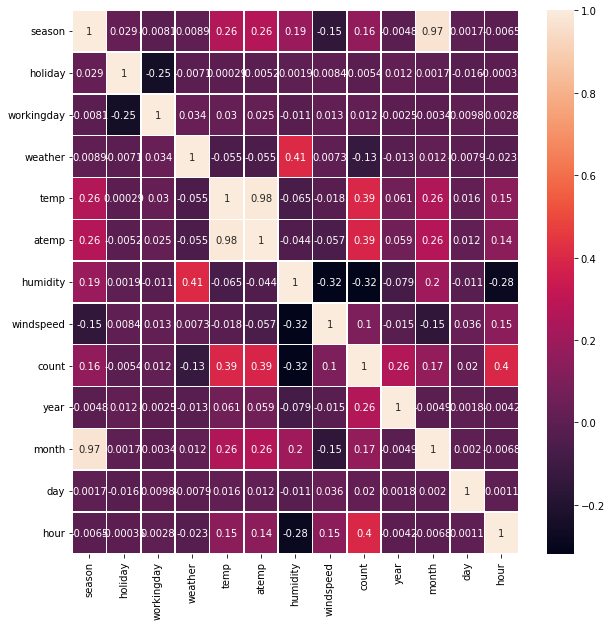

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(figsize=(10,10))
train_corr=train.drop('datetime', axis=1).corr()
sns.heatmap(train_corr, annot=True, linewidths=.5, ax=ax)

There are a high correlations between features "season" and "day" , "temp" and "atemp",  need to drop one of features in each pair. Let's choose season and temp

In [52]:
train.corr()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,month,day,hour
season,1.000000,0.029368,-0.008126,0.008879,0.258689,0.264744,0.190610,-0.147121,0.163439,-0.004797,0.971524,0.001729,-0.006546
holiday,0.029368,1.000000,-0.250491,-0.007074,0.000295,-0.005215,0.001929,0.008409,-0.005393,0.012021,0.001731,-0.015877,-0.000354
workingday,-0.008126,-0.250491,1.000000,0.033772,0.029966,0.024660,-0.010880,0.013373,0.011594,-0.002482,-0.003394,0.009829,0.002780
weather,0.008879,-0.007074,0.033772,1.000000,-0.055035,-0.055376,0.406244,0.007261,-0.128655,-0.012548,0.012144,-0.007890,-0.022740
temp,0.258689,0.000295,0.029966,-0.055035,1.000000,0.984948,-0.064949,-0.017852,0.394454,0.061226,0.257589,0.015551,0.145430
atemp,0.264744,-0.005215,0.024660,-0.055376,0.984948,1.000000,-0.043536,-0.057473,0.389784,0.058540,0.264173,0.011866,0.140343
humidity,0.190610,0.001929,-0.010880,0.406244,-0.064949,-0.043536,1.000000,-0.318607,-0.317371,-0.078606,0.204537,-0.011335,-0.278011
windspeed,-0.147121,0.008409,0.013373,0.007261,-0.017852,-0.057473,-0.318607,1.000000,0.101369,-0.015221,-0.150192,0.036157,0.146631
count,0.163439,-0.005393,0.011594,-0.128655,0.394454,0.389784,-0.317371,0.101369,1.000000,0.260403,0.166862,0.019826,0.400601
year,-0.004797,0.012021,-0.002482,-0.012548,0.061226,0.058540,-0.078606,-0.015221,0.260403,1.000000,-0.004932,0.001800,-0.004234


# **Make category types for these so models know they are not just numbers**



*   AutoGluon originally sees these as ints, but in reality they are int representations of a category.

*   Setting the dtype to category will classify these as categories in AutoGluon.



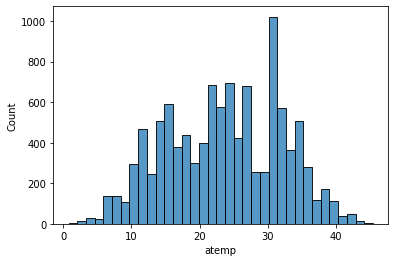

In [56]:
sns.histplot(train['atemp'])

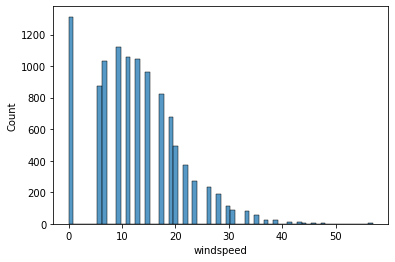

In [57]:
sns.histplot(train['windspeed'])

In [60]:
for each in train.columns:
    print('Feature', each, 'has county of unique values: ', train[each].nunique(), '( ', train[each].unique(),  ')\n with number of values for each unique: ', train[each].value_counts(), '\n')

Feature datetime has county of unique values:  10886 (  ['2011-01-01T00:00:00.000000000' '2011-01-01T01:00:00.000000000'
 '2011-01-01T02:00:00.000000000' ... '2012-12-19T21:00:00.000000000'
 '2012-12-19T22:00:00.000000000' '2012-12-19T23:00:00.000000000'] )
 with number of values for each unique:  2011-01-01 00:00:00    1
2012-05-01 21:00:00    1
2012-05-01 13:00:00    1
2012-05-01 14:00:00    1
2012-05-01 15:00:00    1
                      ..
2011-09-02 04:00:00    1
2011-09-02 05:00:00    1
2011-09-02 06:00:00    1
2011-09-02 07:00:00    1
2012-12-19 23:00:00    1
Name: datetime, Length: 10886, dtype: int64 

Feature season has county of unique values:  4 (  [1 2 3 4] )
 with number of values for each unique:  4    2734
2    2733
3    2733
1    2686
Name: season, dtype: int64 

Feature holiday has county of unique values:  2 (  [0 1] )
 with number of values for each unique:  0    10575
1      311
Name: holiday, dtype: int64 

Feature workingday has county of unique values:  2 (  [0

In [61]:
categorical_columns=['season', 'holiday', 'windspeed', 'workingday', 'weather', 'year', 'month', 'day', 'hour']
for each in categorical_columns:
    train[each] = train[each].astype('category')
    test[each] = test[each].astype('category')

train.dtypes
test.dtypes


datetime      datetime64[ns]
season              category
holiday             category
workingday          category
weather             category
temp                 float64
atemp                float64
humidity               int64
windspeed           category
year                category
month               category
day                 category
hour                category
dtype: object

In [63]:
def f(x):
    if (x > 7) and (x <= 9):
        return 'Early morning'
    elif (x > 9) and (x <= 11 ):
        return 'Morning'
    elif (x > 11) and (x <= 13):
        return'Lunch'
    elif (x > 13) and (x <= 17) :
        return 'Afternoon'
    elif (x > 17) and (x <= 21):
        return'Evening'
    elif (x > 21) or (x < 7):
        return'Late Night'
        
train['part day'] = train['hour'].apply(f)
test['part day'] = test['hour'].apply(f)

In [64]:
def f(x):
    if (x > 0) and (x <= 12):
        return 'Cold atemp'
    elif (x > 12) and (x <= 25 ):
        return 'Mild atemp'
    elif (x > 25):
        return 'Hot atemp'
train['level atemp'] = train['atemp'].apply(f)
test['level atemp'] = test['atemp'].apply(f)
train

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,month,day,hour,part_day,part day,level atemp
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,16,2011,1,1,0,NaN,Late Night,Mild atemp
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,40,2011,1,1,1,NaN,Late Night,Mild atemp
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,32,2011,1,1,2,NaN,Late Night,Mild atemp
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,13,2011,1,1,3,NaN,Late Night,Mild atemp
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,1,2011,1,1,4,NaN,Late Night,Mild atemp
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,336,2012,12,19,19,NaN,Evening,Mild atemp
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,241,2012,12,19,20,NaN,Evening,Mild atemp
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,168,2012,12,19,21,NaN,Evening,Mild atemp
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,129,2012,12,19,22,NaN,Late Night,Mild atemp


In [65]:
def f(x):
    if (x > 0) and (x <= 20 ):
        return 'Not humid'
    elif (x > 20) and (x <= 60 ):
        return 'Mild humid'
    elif (x > 60):
        return 'Very humid'
train['level humidity'] = train['humidity'].apply(f)
test['level humidity'] = test['humidity'].apply(f)
train

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,month,day,hour,part_day,part day,level atemp,level humidity
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,16,2011,1,1,0,NaN,Late Night,Mild atemp,Very humid
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,40,2011,1,1,1,NaN,Late Night,Mild atemp,Very humid
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,32,2011,1,1,2,NaN,Late Night,Mild atemp,Very humid
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,13,2011,1,1,3,NaN,Late Night,Mild atemp,Very humid
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,1,2011,1,1,4,NaN,Late Night,Mild atemp,Very humid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,336,2012,12,19,19,NaN,Evening,Mild atemp,Mild humid
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,241,2012,12,19,20,NaN,Evening,Mild atemp,Mild humid
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,168,2012,12,19,21,NaN,Evening,Mild atemp,Very humid
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,129,2012,12,19,22,NaN,Late Night,Mild atemp,Very humid


In [66]:
def f(x):
    if x == 0:
        return 'No wind'
    elif (x > 0) and (x <= 10 ):
        return 'Mild wind'
    elif (x > 10):
        return 'Very windy'
train['level windspeed'] = train['windspeed'].apply(f)
test['level windspeed'] = test['windspeed'].apply(f)
train

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,month,day,hour,part_day,part day,level atemp,level humidity,level windspeed
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,16,2011,1,1,0,NaN,Late Night,Mild atemp,Very humid,No wind
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,40,2011,1,1,1,NaN,Late Night,Mild atemp,Very humid,No wind
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,32,2011,1,1,2,NaN,Late Night,Mild atemp,Very humid,No wind
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,13,2011,1,1,3,NaN,Late Night,Mild atemp,Very humid,No wind
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,1,2011,1,1,4,NaN,Late Night,Mild atemp,Very humid,No wind
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,336,2012,12,19,19,NaN,Evening,Mild atemp,Mild humid,Very windy
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,241,2012,12,19,20,NaN,Evening,Mild atemp,Mild humid,Very windy
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,168,2012,12,19,21,NaN,Evening,Mild atemp,Very humid,Very windy
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,129,2012,12,19,22,NaN,Late Night,Mild atemp,Very humid,Mild wind


# **Step 5: Rerun the model with the same settings as before, just with more added features and dropped 'temp' and 'season'**

In [70]:
train=train.drop([ 'temp', 'season'], axis=1)
train

,datetime,holiday,workingday,weather,atemp,humidity,windspeed,count,year,month,day,hour,part day,level atemp,level humidity,level windspeed
0,2011-01-01 00:00:00,0,0,1,14.395,81,0.0000,16,2011,1,1,0,Late Night,Mild atemp,Very humid,No wind
1,2011-01-01 01:00:00,0,0,1,13.635,80,0.0000,40,2011,1,1,1,Late Night,Mild atemp,Very humid,No wind
2,2011-01-01 02:00:00,0,0,1,13.635,80,0.0000,32,2011,1,1,2,Late Night,Mild atemp,Very humid,No wind
3,2011-01-01 03:00:00,0,0,1,14.395,75,0.0000,13,2011,1,1,3,Late Night,Mild atemp,Very humid,No wind
4,2011-01-01 04:00:00,0,0,1,14.395,75,0.0000,1,2011,1,1,4,Late Night,Mild atemp,Very humid,No wind
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,0,1,1,19.695,50,26.0027,336,2012,12,19,19,Evening,Mild atemp,Mild humid,Very windy
10882,2012-12-19 20:00:00,0,1,1,17.425,57,15.0013,241,2012,12,19,20,Evening,Mild atemp,Mild humid,Very windy
10883,2012-12-19 21:00:00,0,1,1,15.910,61,15.0013,168,2012,12,19,21,Evening,Mild atemp,Very humid,Very windy
10884,2012-12-19 22:00:00,0,1,1,17.425,61,6.0032,129,2012,12,19,22,Late Night,Mild atemp,Very humid,Mild wind


In [71]:
test=test.drop([ 'temp', 'season'], axis=1)
test

,datetime,holiday,workingday,weather,atemp,humidity,windspeed,year,month,day,hour,part day,level atemp,level humidity,level windspeed
0,2011-01-20 00:00:00,0,1,1,11.365,56,26.0027,2011,1,20,0,Late Night,Cold atemp,Mild humid,Very windy
1,2011-01-20 01:00:00,0,1,1,13.635,56,0.0000,2011,1,20,1,Late Night,Mild atemp,Mild humid,No wind
2,2011-01-20 02:00:00,0,1,1,13.635,56,0.0000,2011,1,20,2,Late Night,Mild atemp,Mild humid,No wind
3,2011-01-20 03:00:00,0,1,1,12.880,56,11.0014,2011,1,20,3,Late Night,Mild atemp,Mild humid,Very windy
4,2011-01-20 04:00:00,0,1,1,12.880,56,11.0014,2011,1,20,4,Late Night,Mild atemp,Mild humid,Very windy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6488,2012-12-31 19:00:00,0,1,2,12.880,60,11.0014,2012,12,31,19,Evening,Mild atemp,Mild humid,Very windy
6489,2012-12-31 20:00:00,0,1,2,12.880,60,11.0014,2012,12,31,20,Evening,Mild atemp,Mild humid,Very windy
6490,2012-12-31 21:00:00,0,1,1,12.880,60,11.0014,2012,12,31,21,Evening,Mild atemp,Mild humid,Very windy
6491,2012-12-31 22:00:00,0,1,1,13.635,56,8.9981,2012,12,31,22,Late Night,Mild atemp,Mild humid,Mild wind


In [72]:
predictor_new_features =TabularPredictor(label="count").fit(
    train_data=train,
    time_limit=600,
    presets="best_quality"
)

No path specified. Models will be saved in: "AutogluonModels/ag-20220419_092219/"
Presets specified: ['best_quality']
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20220419_092219/"
AutoGluon Version:  0.4.0
Python Version:     3.7.13
Operating System:   Linux
Train Data Rows:    10886
Train Data Columns: 15
Label Column: count
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == int and many unique label-values observed).
	Label info (max, min, mean, stddev): (977, 1, 191.57413, 181.14445)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    10968.16 MB
	Train Data (Original)  Memory Usage: 3

Let's distill AutoGluon’s predictor, which is most accurate ensemble-predictor into single models which are simpler/faster and require less memory/compute. Distillation can produce a model that is more accurate than the same model fit directly on the original training data

In [73]:
distilled_model_names = predictor_new_features.distill()

Distilling with teacher='WeightedEnsemble_L3', teacher_preds=soft, augment_method=spunge ...
SPUNGE: Augmenting training data with 48985 synthetic samples for distillation...
Distilling with each of these student models: ['LightGBM_DSTL', 'NeuralNetMXNet_DSTL', 'CatBoost_DSTL', 'RandomForest_DSTL', 'NeuralNetTorch_DSTL']
Fitting 5 L1 models ...
Fitting model: LightGBM_DSTL ...


[1000]	valid_set's rmse: 37.6346
[2000]	valid_set's rmse: 36.9902
[3000]	valid_set's rmse: 36.687
[4000]	valid_set's rmse: 36.5648
[5000]	valid_set's rmse: 36.4203
[6000]	valid_set's rmse: 36.3086
[7000]	valid_set's rmse: 36.2964
[8000]	valid_set's rmse: 36.268
[9000]	valid_set's rmse: 36.2424
[10000]	valid_set's rmse: 36.2045


	-36.2039	 = Validation score   (root_mean_squared_error)
	58.66s	 = Training   runtime
	1.74s	 = Validation runtime
Fitting model: NeuralNetMXNet_DSTL ...
		Starting in v0.5.0, calling TabularNeuralNetMxnetModel will raise an exception.
		Consider instead using TabularNeuralNetTorchModel via "NN_TORCH".
	-34.7379	 = Validation score   (root_mean_squared_error)
	1045.98s	 = Training   runtime
	0.37s	 = Validation runtime
Fitting model: CatBoost_DSTL ...
	-36.5196	 = Validation score   (root_mean_squared_error)
	1371.32s	 = Training   runtime
	0.11s	 = Validation runtime
Fitting model: RandomForest_DSTL ...
	-38.9828	 = Validation score   (root_mean_squared_error)
	107.94s	 = Training   runtime
	0.31s	 = Validation runtime
Fitting model: NeuralNetTorch_DSTL ...
	-40.8945	 = Validation score   (root_mean_squared_error)
	187.11s	 = Training   runtime
	0.04s	 = Validation runtime
Distilling with each of these student models: ['WeightedEnsemble_L2_DSTL']
Fitting model: WeightedEnsemble_L2_D

In [ ]:
model_to_deploy = distilled_model_names[0]
predictions_nf=predictor_new_features.predict(test, model=model_to_deploy)
predictions_nf

In [ ]:
#if predictions contain negative values
predictions_nf[predictions_nf < 0] = 0
predictions_nf

In [ ]:
predictor_new_features=predictor_new_features.fit_summary()

In [ ]:
submission["count"] = predictions_nf
submission.to_csv("submission_dropped_added_features_distill.csv", index=False)

In [ ]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_features.csv -m "new features"

In [ ]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

# New Score of ?

# **Step 6: Hyper parameter optimization**

In [ ]:
import autogluon.core as ag

nn_options = {  # specifies non-default hyperparameter values for neural network models
    'num_epochs': 10,  # number of training epochs (controls training time of NN models)
    'learning_rate': ag.space.Real(1e-4, 1e-2, default=5e-4, log=True),  # learning rate used in training (real-valued hyperparameter searched on log-scale)
    'activation': ag.space.Categorical('relu', 'softrelu', 'tanh'),  # activation function used in NN (categorical hyperparameter, default = first entry)
    'dropout_prob': ag.space.Real(0.0, 0.5, default=0.1),  # dropout probability (real-valued hyperparameter)
}

gbm_options = {  # specifies non-default hyperparameter values for lightGBM gradient boosted trees
    'num_boost_round': 100,  # number of boosting rounds (controls training time of GBM models)
    'num_leaves': ag.space.Int(lower=26, upper=66, default=36),  # number of leaves in trees (integer hyperparameter)
}

hyperparameters = {  # hyperparameters of each model type
                   'GBM': gbm_options,
                   'NN_TORCH': nn_options,  # NOTE: comment this line out if you get errors on Mac OSX
                  }  # When these keys are missing from hyperparameters dict, no models of that type are trained

time_limit = 2*60  # train various models for ~2 min
num_trials = 5  # try at most 5 different hyperparameter configurations for each type of model
search_strategy = 'auto'  # to tune hyperparameters using random search routine with a local scheduler

hyperparameter_tune_kwargs = {  # HPO is not performed unless hyperparameter_tune_kwargs is specified
    'num_trials': num_trials,
    'scheduler' : 'local',
    'searcher': search_strategy,
}

predictor_hpo = TabularPredictor(label='count').fit(
    train, time_limit=600,
    hyperparameters=hyperparameters, hyperparameter_tune_kwargs=hyperparameter_tune_kwargs,
)

In [ ]:
predictor_hpo.fit_summary()

In [ ]:
distilled_model_names = predictor_hpo.distill()

In [ ]:
model_to_deploy = distilled_model_names[0]
predictions_hpo=predictor_hpo.predict(test, model=model_to_deploy)
predictions_hpo

In [ ]:
# Remember to set all negative values to zero
any(predictions_hpo<0)
predictions

In [ ]:
#set
predictions_hpo[predictions_hpo < 0] = 0
predictions_hpo


In [ ]:
# Same submitting predictions
submission["count"] = predictions_hpo
submission.to_csv("submission_new_hpo.csv", index=False)

In [ ]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_hpo.csv -m "new features with hyperparameters"

In [ ]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

# New Score of

# **# Step 7: Write a Report**
# Refer to the markdown file for the full report
# Creating plots and table for report

In [ ]:
# Taking the top model score from each training run and creating a line plot to show improvement
# You can create these in the notebook and save them to PNG or use some other tool (e.g. google sheets, excel)
fig = pd.DataFrame(
    {
        "model": ["initial", "add_features", "hpo"],
        "score": [?, ?, ?]
    }
).plot(x="model", y="score", figsize=(8, 6)).get_figure()
fig.savefig('model_train_score.png')

In [ ]:
# Take the 3 kaggle scores and creating a line plot to show improvement
fig = pd.DataFrame(
    {
        "test_eval": ["initial", "add_features", "hpo"],
        "score": [?, ?, ?]
    }
).plot(x="test_eval", y="score", figsize=(8, 6)).get_figure()
fig.savefig('model_test_score.png')

# **Hyperparameter table**

In [ ]:
# The 3 hyperparameters we tuned with the kaggle score as the result
pd.DataFrame({
    "model": ["initial", "add_features", "hpo"],
    "hpo1": [?, ?, ?],
    "hpo2": [?, ?, ?],
    "hpo3": [?, ?, ?],
    "score": [?, ?, ?]
})